In [1]:
from pyspark.sql import SparkSession
import gzip
import os
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count, countDistinct, isnan, when, to_date
from pyspark.sql.functions import col, to_date, avg, min, max

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("GHCN Observation Analysis") \
    .getOrCreate()

# Set the directory path
dir_path = '../ghcn'

# Create a list to store file paths
file_paths = [os.path.join(dir_path, filename) for filename in os.listdir(
    dir_path) if filename.endswith('.json.gz')]

# Create a DataFrame by reading all the .json.gz files
df = spark.read.json(file_paths)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/10 11:30:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Show basic information
print("Schema of the dataset:")
df.printSchema()

print("First few rows of the dataset:")
df.show(5, truncate=False)

Schema of the dataset:
root
 |-- date: string (nullable = true)
 |-- elevation: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- observation: string (nullable = true)
 |-- station: string (nullable = true)
 |-- value: long (nullable = true)

First few rows of the dataset:
+----------+---------+--------+---------+------------------+-----------+-----------+-----+
|date      |elevation|latitude|longitude|name              |observation|station    |value|
+----------+---------+--------+---------+------------------+-----------+-----------+-----+
|2014-09-16|176.0    |45.35   |-80.05   |PARRY SOUND CCG   |TMAX       |CA006116257|159  |
|2014-09-16|176.0    |45.35   |-80.05   |PARRY SOUND CCG   |PRCP       |CA006116257|2    |
|2014-09-16|250.0    |44.6    |-79.4333 |ORILLIA BRAIN     |TMAX       |CA006115811|170  |
|2014-09-16|250.0    |44.6    |-79.4333 |ORILLIA BRAIN     |PRCP       |CA006115811

In [4]:
# 1. Count rows and columns
row_count = df.count()
col_count = len(df.columns)
print(f"Number of rows: {row_count}")
print(f"Number of columns: {col_count}")
# 2. List all unique observation types
print("Unique observation types:")
df.select("observation").distinct().show(truncate=False)

Number of rows: 89418533
Number of columns: 8
Unique observation types:


+-----------+
|observation|
+-----------+
|TMAX       |
|PRCP       |
+-----------+



In [5]:
# 3. Handle missing values
print("Count of missing values per column:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# 4. Summary statistics for numerical columns
print("Summary statistics for numerical columns:")
numerical_columns = [field.name for field in df.schema.fields if str(field.dataType) in ['DoubleType', 'IntegerType']]
df.select(numerical_columns).describe().show()

Count of missing values per column:


+----+---------+--------+---------+--------+-----------+-------+-----+
|date|elevation|latitude|longitude|    name|observation|station|value|
+----+---------+--------+---------+--------+-----------+-------+-----+
|   0| 44795014|44795014| 44795014|44795014|          0|      0|    0|
+----+---------+--------+---------+--------+-----------+-------+-----+

Summary statistics for numerical columns:
+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [6]:
# 5. Analyze `observation` types
print("Count of records by observation type:")
df.groupBy("observation").count().orderBy("count", ascending=False).show()

# 6. Analyze time-based patterns (if the dataset has a date column, e.g., `date`)
if 'date' in df.columns:
    print("Converting 'date' column to Spark date format and analyzing yearly trends:")
    df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
    df.groupBy("date").count().orderBy("date", ascending=True).show()

# 7. Explore relationships between key columns
# Example: Relationship between `observation` and another column (e.g., `value`)
if 'value' in df.columns:
    print("Average 'value' per observation type:")
    df.groupBy("observation").avg("value").orderBy("avg(value)", ascending=False).show()

Count of records by observation type:


+-----------+--------+
|observation|   count|
+-----------+--------+
|       PRCP|60734587|
|       TMAX|28683946|
+-----------+--------+

Converting 'date' column to Spark date format and analyzing yearly trends:


+----------+-----+
|      date|count|
+----------+-----+
|2012-01-01|78203|
|2012-01-02|79390|
|2012-01-03|79946|
|2012-01-04|80563|
|2012-01-05|80639|
|2012-01-06|80441|
|2012-01-07|79424|
|2012-01-08|79579|
|2012-01-09|80743|
|2012-01-10|81394|
|2012-01-11|81341|
|2012-01-12|81328|
|2012-01-13|80430|
|2012-01-14|78874|
|2012-01-15|78861|
|2012-01-16|79678|
|2012-01-17|80566|
|2012-01-18|80865|
|2012-01-19|80082|
|2012-01-20|80521|
+----------+-----+
only showing top 20 rows

Average 'value' per observation type:


+-----------+------------------+
|observation|        avg(value)|
+-----------+------------------+
|       TMAX| 167.9069814174103|
|       PRCP|25.910079391829896|
+-----------+------------------+



In [7]:
# Ensure the "date" column is in proper date format
df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# Calculate the minimum and maximum dates
date_range = df.agg(min("date").alias("start_date"), max("date").alias("end_date")).collect()[0]

# Print the date range
print("Date Range of the Data:")
print(f"Start Date: {date_range['start_date']}")
print(f"End Date: {date_range['end_date']}")

Date Range of the Data:
Start Date: 2012-01-01
End Date: 2014-12-31


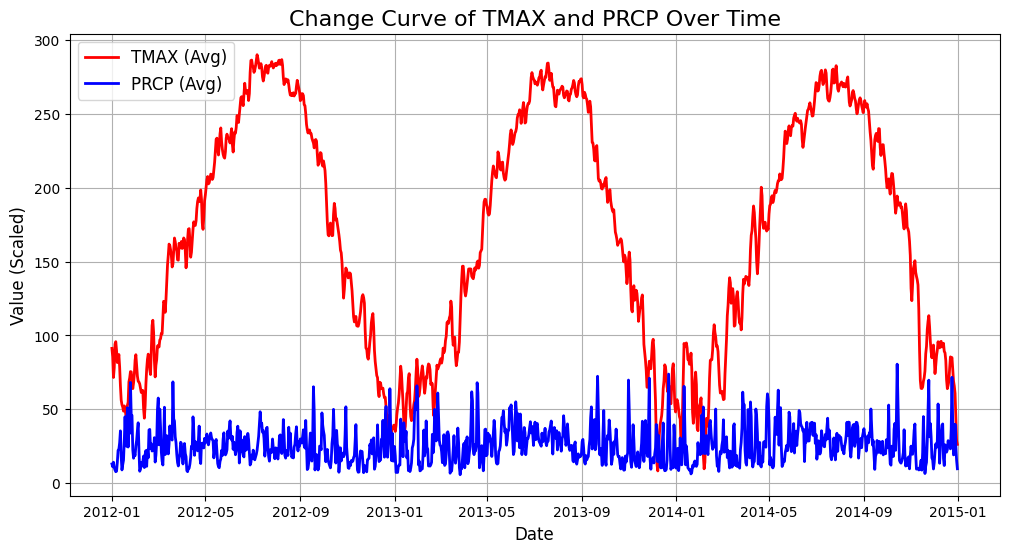

In [8]:
# Filter data for TMAX and PRCP observations
tmax_df = df.filter(col("observation") == "TMAX")
prcp_df = df.filter(col("observation") == "PRCP")

# Aggregate by date to calculate average values
tmax_agg = tmax_df.groupBy("date").agg(avg("value").alias("avg_tmax")).orderBy("date")
prcp_agg = prcp_df.groupBy("date").agg(avg("value").alias("avg_prcp")).orderBy("date")

# Convert Spark DataFrames to Pandas for plotting
tmax_pd = tmax_agg.toPandas()
prcp_pd = prcp_agg.toPandas()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot TMAX
plt.plot(tmax_pd["date"], tmax_pd["avg_tmax"], label="TMAX (Avg)", color="red", linewidth=2)

# Plot PRCP
plt.plot(prcp_pd["date"], prcp_pd["avg_prcp"], label="PRCP (Avg)", color="blue", linewidth=2)

# Add labels, title, and legend
plt.title("Change Curve of TMAX and PRCP Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (Scaled)", fontsize=12)
plt.legend(fontsize=12)
plt.grid()

# Show the plot
plt.show()